[Understanding F-Algebras
1 Oct 2013 Bartosz Milewski](https://www.schoolofhaskell.com/user/bartosz/understanding-algebras)

In [14]:
{-# LANGUAGE DeriveFunctor #-}
{-# LANGUAGE TypeFamilies #-}
{-# LANGUAGE StandaloneDeriving #-}

import Data.Functor.Foldable -- recursion-schemes

what makes algebras stand appart from linear spaces is the **presence of vector multiplication**: a bilinear product of vectors whose **result is another vector** (as opposed to inner product, which produces a scalar)

F-algebras reduce the notion of an algebra to the bare minimum. 
Three basic ingredients of an algebra are: a ***functor***, a ***type*** (not the functor), and a ***function***

There is a very **general way of evaluating arbitrary expressions** using ***catamorphisms***, which reduces to **foldr** when applied to lists 

In [2]:
data ExprF a f = Const a --f is hole which actually has a meaning of functor which happens to be (Fix ExprF) itself 
        | Add f f
        | Mul f f   deriving Show

define more complex recursive structure using **simpler, nonrecursive** ExprF !!!

In [42]:
newtype Fix f = Fx (f (Fix f)) 
--deriving instance Show (Fix f) -- No instance for (Show (f (Fix f))) arising from a use of ‘showsPrec’
-- FORM expressions

val :: Fix ExprFInt
val = Fx (Const 12)

type ExprFInt = ExprF Int

testExpr1 = Fx $ (Fx $ (Fx $ Const 2) `Add` 
                (Fx $ Const 3)) `Mul` (Fx $ Const 4)

:t testExpr1                  
testExpr2 = Fx $ (Fx $ (Fx $ Const 2) `Add` 
                (Fx $ Const 3)) `Mul` Fx((Fx $ Const 3) `Mul` (Fx $ Const 4))                
:t testExpr2              -- !!! NOTE the same type

testExpr1 :: forall a. Num a => Fix (ExprF a)

testExpr2 :: forall a. Num a => Fix (ExprF a)

now EVALUATE formed expressions; Decomposition: non-recursive simpler top-level evaluator is **alg**
and the recursive one (for evaluating children) is **eval**; eval is **defined once** in functor definition!!!

First, we need to be able to ***map eval over the children*** of an expression. Did somebody mentioned mapping? That means **we need a functor**!

NOTE! The following functor is **defined for nonrecursive/top level** type ExprF

In [4]:
instance Functor (ExprF a) where
    fmap eval (Const ia) = Const ia
    fmap eval (left `Add` right) = eval left `Add` eval right
    fmap eval (left `Mul` right) = eval left `Mul` eval right

In [5]:
-- top level evaluator alg; hole is replaced with this type, this is result of evaluation
alg :: ExprFInt Int -> Int

alg (Const i)   = i
alg (x `Add` y) = x + y
alg (x `Mul` y) = x * y

Just to show that the carrier type is arbitrary, let me define **another evaluator that returns a string**.
NOTE! ***Expression type stays the same!*** only evaluates to String instead Int

In [6]:
import Data.Char
alg' :: (ExprF Int) String -> String  -- String is a carrier

alg' (Const i)   = [chr (ord 'a' + i)]
alg' (x `Add` y) = x ++ y
alg' (x `Mul` y) = concat [[a, b] | a <- x, b <- y]

An F-algebra consists of:

1. ***f*** - an **endofunctor F** in a category C (functor is parametriesed by **b** which is bound here to concrete type Int),
1. ***a*** - an **object A** in that category, **carrier** (Int or String) and
1. ***fun:: f a -> a*** a **morphism from F(A) to A**.

Now following makes sense:

In [7]:
--TODO import Control.Functor.Algebra
type Algebra f a = f a -> a

For a given functor f and a carrier type a the algebra is defined by **specifying just one function**. Often this function itself is called the algebra, hence my use of the name ***alg***

In [8]:
type SimpleA = Algebra ExprFInt Int -- My simple algebra
-- this is defined for this simple nonrecursive top level data structure

-- earlier defined alg had type: alg :: ExprFInt Int -> Int
alg :: SimpleA
alg (Const i)   = i
alg (x `Add` y) = x + y
alg (x `Mul` y) = x * y
:t alg

alg :: SimpleA

There are many algebras based on a given functor (many versions of function ***alg***), 

But there is **one special algebra** to bind them all -- the ***INITIAL*** algebra. instead of using **Int** or **String**, ***use (Fix ExprFInt)*** as a CARRIER/result of evaluation!!!

In [9]:
type ExprInitAlg = Algebra ExprFInt (Fix ExprFInt)

ex_init_alg :: ExprFInt (Fix ExprFInt) -> Fix ExprFInt
ex_init_alg = Fx
-- ex_init_alg = Fx (ExprFInt (Fix ExprFInt)) 

 What does this "evaluator" evaluate? Given (ExprF Expr) it produces recursive type **Expr** !!!!!!!!!

In [37]:
expr = Add (Fx $ Const (2::Int)) (Fx $ Const (3::Int))
:t expr

expr' = Fx expr -- only one level because derived from top level type, but it is now recursive type
:t expr' 

expr :: forall a. ExprF a (Fix (ExprF Int))

expr' :: Fix (ExprF Int)

In [11]:
expr2 = Fx (Const (2::Int))
:t expr2

expr2 :: Fix (ExprF Int)

In [43]:
r = ex_init_alg expr -- result is an "encoded expression" itself !!!
-- it is Fx $ Add (Fx $ Const 2) (Fx $ Const 3)
--TODO how to: derive instance Show (Fix ExprFInt)
:t r

r :: Fix ExprFInt

This evaluator ***doesn't reduce anything*** like the evaluators we've been using so far. It is **not lossy**. 

In this sense, the algebra we have just defined is **at least as powerful as all other algebras based on the same functor**. That's why it's called the initial algebra.

In fact, a homomorphism of algebras is fully specified by a function that **maps one carrier to another** and obeys certain properties. Since the carrier of the intial algebra is **Fix f**, we need a function `g`:

In [71]:
g :: Fix f -> a -- a is carrier
g = undefined
alg :: f a -> a
alg = undefined

The special property g has to obey is that it shouldn't matter whether we first use the initial algebra's evaluator and then apply `g`, or first apply `g` (through fmap) and then the second algebra's evaluator, `alg`
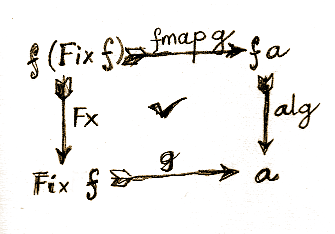

with one reversal of arrow Fix <-> unFix
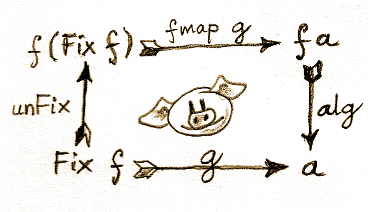

The crucial observation is that Fx is a **losless** transformation and it **can be easily inverted**. The inverse of Fx is ***unFix***:

In [51]:
unFix :: Fix f -> f (Fix f)
unFix (Fx x) = x

In [53]:
g = alg . fmap g . unFix


We can abstract the evaluation further by factoring out the dependence on alg (redefining  `g = cata alg`):

In [56]:
cata :: Functor f => (f a -> a) -> Fix f -> a
cata alg = alg . fmap (cata alg) . unFix -- recursive evaluator

It takes an arbitrary algebra, which is a non-recursive function `f a -> a`, and returns an evaluator function, `(Fix f -> a)`. This function takes an expression of the type `Fix f` and evaluates it down to type a. A catamorphism lets us evaluate arbitrarily nested expressions!

In [69]:
type SimpleA = Algebra ExprFInt Int

alg :: SimpleA
alg (Const i)   = i
alg (x `Add` y) = x + y
alg (x `Mul` y) = x * y

eval :: Fix ExprFInt -> Int
-- eval = cata alg = alg . fmap (cata alg) . unFix
eval = cata alg

testExpr = Fx $ (Fx $ (Fx $ Const 2) `Add` 
                (Fx $ Const 3)) `Mul` (Fx $ Const 4)
:t testExpr                

print $ eval testExpr

testExpr :: forall a. Num a => Fix (ExprF a)

20

1. Just like recursive functions are defined as fixed points of regular functions, recursive (nested) data structures can be defined as fixed points of regular type constructors.
1. Functors are interesting type constructors because they give rise to nested data structures that support recursive evaluation (generalized folding).
1. An F-algebra is defined by a functor f, a carrier type a, and a function from f a to a.
1. There is one initial algebra that maps into all algebras defined over a given functor. This algebra's carrier type is the fix point of the functor in question.
1. The unique mapping between the initial algebra and any other algebra over the same functor is generated by a catamorphism.
1. Catamophism takes a simple algebra and creates a recursive evaluator for a nested data structure (the fix point of the functor in question). This is a generalization of list folding to arbitrary recursive data structures.
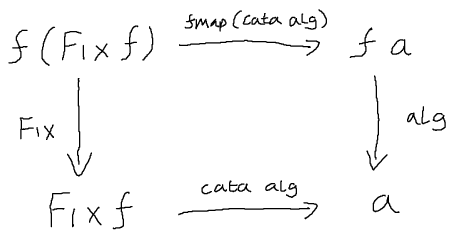

In [23]:
type Expr a = Fix (ExprF a) 

